In [1]:
# Step 1. Grab a random assortment of frames from cab_ride_trimmed.py

import cv2
import numpy as np
import random
from tqdm import tqdm

np.random.seed(42)

def random_frames_from_video(video_path, num_frames=5):
    """
    Extracts random frames from a video and returns them as a list of NumPy arrays.
    
    Parameters:
        video_path (str): Path to the video file.
        num_frames (int): Number of random frames to extract.
        
    Returns:
        list: NumPy array of NumPy arrays representing the frames.
    """
    # Open the video using OpenCV
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error: Couldn't open the video file.")
        return []

    frames = []

    for _ in tqdm(range(num_frames)):
        # Get a random frame number
        frame_num = random.randint(0, total_frames - 1)
        # Set the video position to the frame number
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        # Read the frame
        ret, frame = cap.read()

        if ret:
            frames.append(frame)

    # Release the video capture object
    cap.release()

    # Convert frames to numpy array
    frames = np.array(frames)
    
    return frames

# Extract random frames from the video
frames = random_frames_from_video('cab_ride_trimmed.mkv', num_frames=100)
width = frames.shape[1]
height = frames.shape[2]
random_indices = np.random.permutation(width * height) # for shuffling later...

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.09it/s]


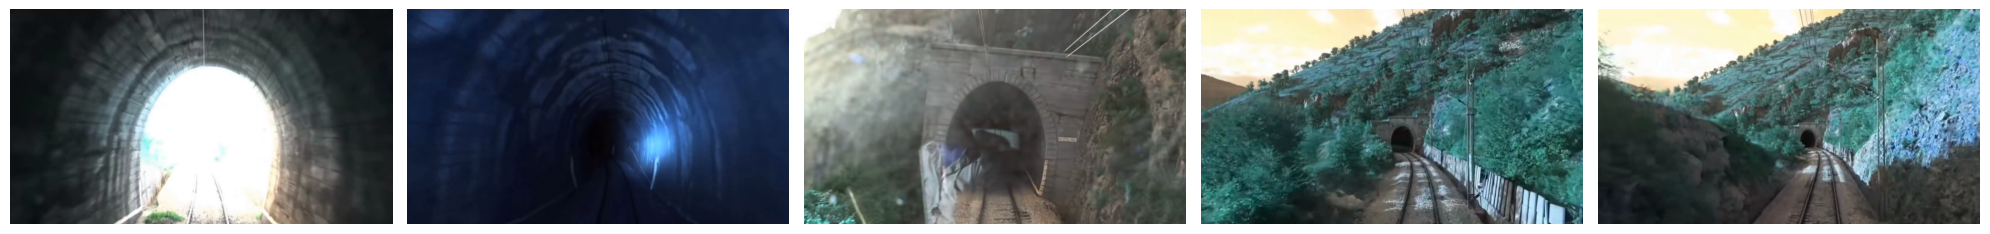

shape: (720, 1280, 3)


In [2]:
# Step 2: preview a random sample of images

import matplotlib.pyplot as plt

# Display up to 5 frames
display_frames = frames[:5]

fig, axs = plt.subplots(1, len(display_frames), figsize=(20, 5))

for ax, frame in zip(axs, display_frames):
    ax.imshow(frame)
    ax.axis('off')

plt.tight_layout()
plt.show()
print("shape:", frames[0].shape)

In [8]:
# Step 3: split each pixel position into its respective color series
# (AKA: TVs)

def pixel_color_series(x_position, y_position):
    return frames[:, x_position, y_position]

def tv(position):
    # select a random position so that there aren't any clues about where the TV goes
    position = random_indices[position]

    # convert to an x, y position
    x_position = position % width
    y_position = position // width
    return frames[:, x_position, y_position]

tvs = []
for i in range(height * width):
    tvs.append(tv(i))

# first, try the top left pixel
# np.all(pixel_color_series(10, 0) == tv(10))

At this point, we now have each TV stored in the list "tvs".

We should now be applying UMAP to the TVs!

In [9]:
len(tvs)

921600